0it [00:00, ?it/s]

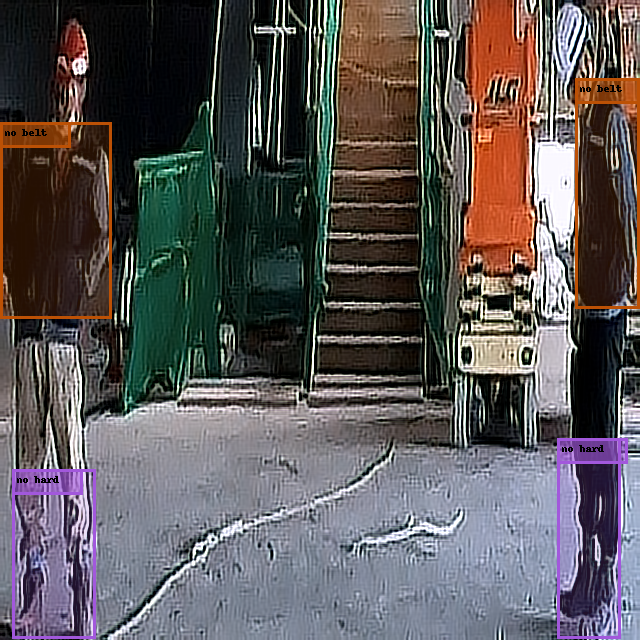

1it [00:00,  6.24it/s]

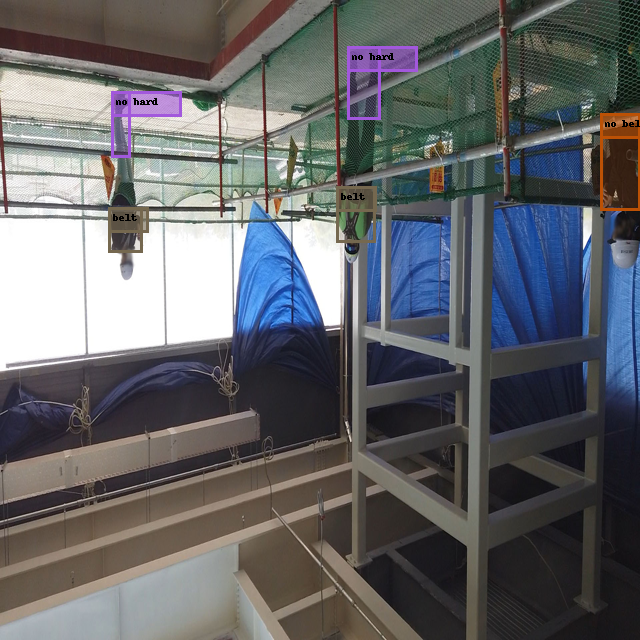

2it [00:00,  5.39it/s]

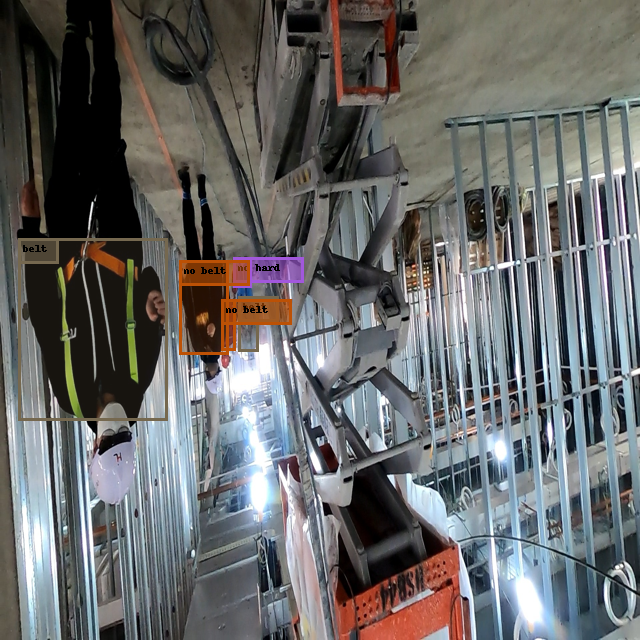

2it [00:01,  1.22it/s]


In [1]:
# bounding box가 잘 형성 되었는지 확인하는 부분
import random
import numpy as np
import os
import shutil
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from PIL import Image, ImageDraw, ImageFont, ImageOps
from tqdm import tqdm
import PIL.ImageOps

dir_main = "./yolov5"
filenames_image = glob(f"{dir_main}/datasets/images/train/*.png")
filenames_label = [filename.replace('images', 'labels').replace('png', 'txt') for filename in filenames_image]
classes = ["belt", "no belt", "hard", "no hard", "helmet", "no helmett"]

color = []
# color 생성하는 부분
for _ in range(6):
    c = list(np.random.choice(range(256), size=3)) + [255]
    c = tuple(c)
    color.append(c)

# annotation 정보가 제대로 저장됐는지 확인하기 위한 bounding box를 시각화하는 함수
def draw_bbox(draw, bbox, label, color=(0, 255, 0, 255), confs=None, size=15):
    font = ImageFont.load_default()
    # font = ImageFont.truetype("arial", size=size)
    draw.rectangle(bbox, outline=color, width =3)
    def set_alpha(color, value):
        background = list(color)
        background[3] = value
        return tuple(background)
    background = set_alpha(color, 50)
    draw.rectangle(bbox, outline=color, fill=background, width =3)
    background = set_alpha(color, 150)
    text = f"{label}" + ("" if confs==None else f":{conf:0.4}")
    text_bbox = bbox[0], bbox[1], bbox[0]+len(text)*10, bbox[1]+25
    draw.rectangle(text_bbox, outline=color, fill=background, width =3)
    draw.text((bbox[0]+5, bbox[1]+5), text, (0,0,0), font=font)

cnt = 3

for filename_image, filename_label in tqdm(zip(filenames_image, filenames_label)):
    img = Image.open(filename_image)
    img = img.resize((640, 640))
    width, height = img.size
    draw = ImageDraw.Draw(img, 'RGBA')
    with open(filename_label, 'r') as f:
        labels = f.readlines()
        # strip: 개행 문자 제거.
        labels = list(map(lambda s: s.strip().split(), labels))
    # bounding box를 그리는 부분
    for label in labels:
        # class는 0부터 시작!
        cls = int(label[0])
        x, y, w, h = map(float, label[1:])
        x1, x2 = width * (x-w/2), width * (x+w/2)
        y1, y2 = height * (y-h/2), height * (y+h/2)
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        draw_bbox(draw, bbox=(x1, y1, x2, y2), label=classes[cls], color=color[cls], size=15)
    img.show()

    cnt -= 1
    if cnt ==0:
        break

In [2]:
# check label_file
# dataset은 augmentation 적용 전의 학습 데이터 파일
# dataset2은 Augmentation 적용 후의 학습 데이터 파일
import os
files1 = "./yolov5/dataset/labels/train"
under1 = os.listdir(files1)
file1 = [os.path.join(files1, u) for u in under1]
files2 = "./yolov5/dataset2/labels/train"
under2 = os.listdir(files2)
file2 = [os.path.join(files2, u) for u in under2]
def check_files(F):
    belt, nobelt, hard, nohard, helmet, nohelmet = 0, 0, 0, 0, 0, 0
    for f in tqdm(F):
        with open(f, "r", encoding = "utf-8") as t:
            data = t.readlines()
        for d in data:
            if d[0] == '0':
                belt += 1
            if d[0] == "1":
                nobelt += 1
            if d[0] == "2":
                hard += 1
            if d[0] == "3":
                nohard += 1
            if d[0] == "4":
                helmet += 1
            if d[0] == '5':
                nohelmet += 1
    return belt, nobelt, hard, nohard, helmet, nohelmet
classes1 = check_files(file1)
classes2 = check_files(file2)

100%|██████████| 6511/6511 [00:15<00:00, 433.76it/s] 


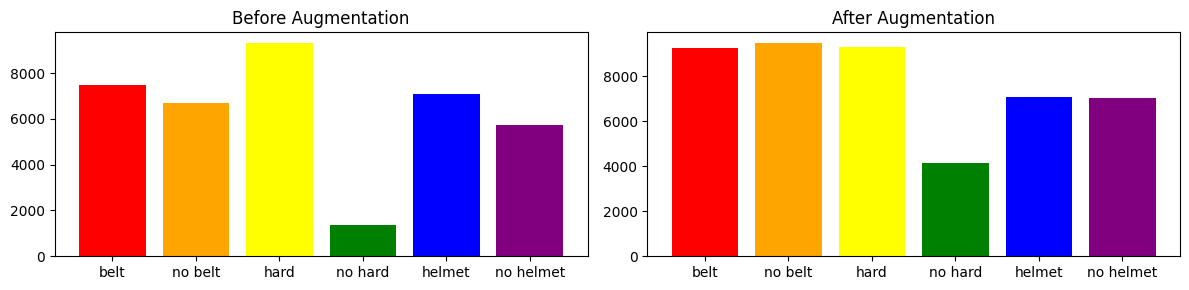

In [3]:
plt.figure(figsize = (12, 3))
classname = ["belt", "no belt", "hard", "no hard", "helmet", "no helmet"]
colors = ["red", "orange", "yellow", "green", "blue", "purple"]
plt.subplot(1,2,1)
plt.title("Before Augmentation")
bar1 = plt.bar(classname, classes1, color = colors)
# plt.legend(bar1, classname, loc = "upper right")
plt.subplot(1, 2, 2)
plt.title("After Augmentation")
bar2 = plt.bar(classname, classes2, color = colors)
# plt.legend(bar2, classname)
plt.tight_layout()
plt.savefig("/mnt/workspace/MyCanvas/yolov5/number_of_cls.png")

### Train 부분
Parsing 부분
- -- img: image size 지정(640으로 Resize)
- -- batch-size: batch_size 
- -- epochs: epoch 수
- -- data: yaml 파일(train, validation, number of classes, class의 이름 지정된 파일)
- -- hyp: hyperparameter 지정(yaml 형식) / 종류는 scratch-low, med, high로 각각 learning rate의 높은 정도에 따라 다르다. ※ 참고사항: f1_gamma는 default로는 0이다. class imbalance의 문제가 있는 경우 hyperparameter yaml 파일에서 f1_gamma 부분을 0보다 큰 수로 지정하면 focal loss를 바탕으로 학습을 진행한다.
- -- optimizer: default로는 SGD이며 Adam, AdamW로 변경 가능하다.
- -- device: 환경에 맞는 device 지정.(default는 cpu, 0, 1, 2, 3을 통해 cuda 활용)
- -- weights: 가중치 체크포인트 파일 지정.

In [ ]:
!python3 train.py --data /mnt/workspace/MyCanvas/yolov5/cfg.yaml --weights /mnt/workspace/MyCanvas/yolov5/best.pt --batch 16 --device 0 --workers 0 --optimizer 'AdamW' --img 640 --cos-lr --hyp /mnt/workspace/MyCanvas/yolov5/data/hyps/hyp.scratch-low.yaml --epochs 100 --patience 30 --label-smoothing 0.1 

### Validation 부분
Parsing
- --data : cfg.yaml에 valid 이미지 파일 경로를 불러온다
- --weights: 가중치 저장 경로를 지정
- --device: gpu or cpu
- --verbose: 결과치를 print하는 것의 여부

In [6]:
!python val.py --data /mnt/workspace/MyCanvas/yolov5/cfg.yaml --weights /mnt/workspace/MyCanvas/yolov5/runs/train/exp4/weights/best.pt --device 'cpu' --verbose --workers 0

val: data=/mnt/workspace/MyCanvas/yolov5/cfg.yaml, weights=['/mnt/workspace/MyCanvas/yolov5/runs/train/exp4/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=cpu, workers=0, single_cls=False, augment=False, verbose=True, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-231-gc2f131a Python-3.8.13 torch-1.10.1 CPU

Fusing layers... 
Model summary: 267 layers, 46135203 parameters, 0 gradients, 107.7 GFLOPs
val: Scanning /mnt/workspace/MyCanvas/yolov5/final_data_/labels/valid.cache... 1
                 Class     Images  Instances          P          R      mAP50   
                   all       1193      10655      0.586      0.711      0.662      0.321
                  Belt       1193       2753       0.82      0.793      0.837      0.394
               No Belt       1193       1439      0.424      0.791      0.657      0.315
      

In [7]:
!python val.py --data /mnt/workspace/MyCanvas/yolov5/cfg.yaml --weights /mnt/workspace/MyCanvas/yolov5/runs/train/exp9/weights/best.pt --device 'cpu' --verbose --workers 0

val: data=/mnt/workspace/MyCanvas/yolov5/cfg.yaml, weights=['/mnt/workspace/MyCanvas/yolov5/runs/train/exp9/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=cpu, workers=0, single_cls=False, augment=False, verbose=True, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-231-gc2f131a Python-3.8.13 torch-1.10.1 CPU

Fusing layers... 
Model summary: 267 layers, 46135203 parameters, 0 gradients, 107.7 GFLOPs
val: Scanning /mnt/workspace/MyCanvas/yolov5/final_data_/labels/valid.cache... 1
                 Class     Images  Instances          P          R      mAP50   
                   all       1193      10655      0.721      0.694      0.735      0.428
                  Belt       1193       2753      0.822      0.885       0.87       0.44
               No Belt       1193       1439      0.695      0.688      0.746       0.39
      

In [8]:
!python val.py --data /mnt/workspace/MyCanvas/yolov5/cfg.yaml --weights /mnt/workspace/MyCanvas/yolov5/runs/train/exp11/weights/best.pt --device 'cpu' --verbose --workers 0

val: data=/mnt/workspace/MyCanvas/yolov5/cfg.yaml, weights=['/mnt/workspace/MyCanvas/yolov5/runs/train/exp11/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=cpu, workers=0, single_cls=False, augment=False, verbose=True, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-231-gc2f131a Python-3.8.13 torch-1.10.1 CPU

Fusing layers... 
Model summary: 267 layers, 46135203 parameters, 0 gradients, 107.7 GFLOPs
val: Scanning /mnt/workspace/MyCanvas/yolov5/final_data_/labels/valid.cache... 1
                 Class     Images  Instances          P          R      mAP50   
                   all       1193      10655       0.73      0.733      0.761      0.449
                  Belt       1193       2753      0.806      0.912      0.875      0.453
               No Belt       1193       1439      0.695       0.68      0.748        0.4
     

### detection
- --source: 임의의 탐지하고자 하는 이미지 파일의 경로
- --weights: checkpoint file의 경로
- --device: gpu or cpu

In [ ]:
!python detect.py --source ./yolov5/sample --weights ./yolov5/runs/train/exp4/weights/best.pt --device "0"